# MLflow avanzado: Optimización de hiperparámetros y registro de modelos
 
En este notebook, exploraremos algunas de las funciones más avanzadas de MLflow, incluyendo:

-   **Optimización de hiperparámetros:** Usar Optuna para encontrar los mejores hiperparámetros para nuestro modelo y registrar los resultados en MLflow.
-   **Registro de modelos:** Registrar el mejor modelo en el Registro de Modelos de MLflow para versionado y despliegue.

In [2]:
import os 
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import pickle

## **Cargamos datos "procesados"**

In [3]:
df_jan = pd.read_parquet("data/processed/jan.parquet")
df_feb = pd.read_parquet("data/processed/feb.parquet")


## **Definir columnas a modelar**

In [4]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ["trip_distance"]

## Definir set de train y test

In [5]:
df_train = df_jan
df_val = df_feb

## **Preprocesar**

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

df_train = df_train.copy()
df_val   = df_val.copy()
df_train["categorical_dict"] = df_train[categorical].to_dict(orient="records")
df_val["categorical_dict"]   = df_val[categorical].to_dict(orient="records")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", DictVectorizer(), "categorical_dict"),
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), numerical),
    ]
)

X_train = preprocessor.fit_transform(df_train)
y_train = df_train["duration"].values
X_val   = preprocessor.transform(df_val)
y_val   = df_val["duration"].values

## **Entrenar**

Antes de ejecutar lo siguiente correr en la terminal en la misma carpeta donde esta el notebook:

`mlflow server --backend-store-uri sqlite:///backend.db`



In [7]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [8]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://127.0.0.1:5000'


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

experiment_name = "rf-nyc-taxi"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

🏃 View run powerful-flea-860 at: http://127.0.0.1:5000/#/experiments/1/runs/7c4abb44cbcb4243993f752019bb6a74
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## **Probando otro modelo**

In [10]:
import xgboost as xgb

with mlflow.start_run():
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

🏃 View run abrasive-grouse-722 at: http://127.0.0.1:5000/#/experiments/1/runs/3f716295467e40609d4dabf18e9e47fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## **Probando autologgin**

In [11]:
import mlflow

experiment_name = "rf-nyc-taxi-autolog"
mlflow.set_experiment(experiment_name)
mlflow.autolog()

with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)


2025/10/29 20:30:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/29 20:30:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/10/29 20:30:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run kindly-perch-21 at: http://127.0.0.1:5000/#/experiments/2/runs/f97123d08f604dc18919110f82cdc2fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## **Optimización de Hiperparametros**

## **¿Por qué es importante la optimización de hiperparámetros?**

En ML, los hiperparámetros son como los “ajustes” que le damos a nuestros modelos antes de entrenarlos. Cosas como la cantidad de árboles en un Random Forest, la profundidad máxima, o la tasa de aprendizaje en un modelo de boosting. Elegir bien estos valores puede marcar la diferencia entre un modelo mediocre y uno realmente bueno.

Optimizar los hiperparámetros no es solo cuestión de probar al azar: es un proceso sistemático para encontrar la mejor combinación posible, y así lograr que nuestro modelo aprenda mejor y generalice bien a datos nuevos. Si no los ajustamos, podemos quedarnos con un modelo que no aprovecha todo su potencial.

## **Usando Optuna**

Para facilitar este proceso, existen herramientas como **Optuna**, que nos ayudan a buscar automáticamente los mejores hiperparámetros de manera eficiente e inteligente. Optuna prueba diferentes combinaciones, aprende de los resultados y se enfoca en las opciones más prometedoras, ahorrándonos mucho tiempo y esfuerzo.

En resumen: dedicarle tiempo a la optimización de hiperparámetros, usando herramientas como Optuna, es clave para sacar el máximo provecho de nuestros modelos de ML.

<img src="optim.png">

In [12]:
import optuna

mlflow.set_experiment("nyc-taxi-experiment-optuna")

def objective(trial):
    with mlflow.start_run():
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
            'max_depth': trial.suggest_int('max_depth', 1, 20, 1),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 6, 1),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4, 1),
            'random_state': 42,
            'n_jobs': -1
        }
        mlflow.log_params(params)

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

    return rmse

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100)

2025/10/29 20:30:38 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment-optuna' does not exist. Creating a new experiment.
[I 2025-10-29 20:30:38,698] A new study created in memory with name: no-name-41160749-f495-4ada-9706-5e4c408893ac
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were 

🏃 View run bouncy-snail-205 at: http://127.0.0.1:5000/#/experiments/3/runs/9bb202d2f83944fd90e6bb093fccda71
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run wistful-yak-887 at: http://127.0.0.1:5000/#/experiments/3/runs/e7f07891d67b49b49c35f16604ca25de
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:30:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:30:44,091] Trial 2 finished with value: 5.034253440524673 and parameters: {'n_estimators': 34, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 5.034253440524673.


🏃 View run vaunted-dove-136 at: http://127.0.0.1:5000/#/experiments/3/runs/c201a853493c4293ab1ab361efe8ea7c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run thoughtful-bug-147 at: http://127.0.0.1:5000/#/experiments/3/runs/f2636851a7104697b922211e7a8008cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:30:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:30:47,517] Trial 4 finished with value: 5.103515983327105 and parameters: {'n_estimators': 22, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 5.034253440524673.
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2

🏃 View run loud-mole-172 at: http://127.0.0.1:5000/#/experiments/3/runs/7115dbb5c2a340cd9b1bed1c070fb5cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:30:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:30:48,986] Trial 5 finished with value: 5.769795066797643 and parameters: {'n_estimators': 35, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 5.034253440524673.
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2n

🏃 View run abundant-loon-583 at: http://127.0.0.1:5000/#/experiments/3/runs/8e99db287fd14b279cb5bad38d13fb90
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:30:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:30:50,922] Trial 6 finished with value: 5.048056486763829 and parameters: {'n_estimators': 28, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 2 with value: 5.034253440524673.


🏃 View run wistful-ram-99 at: http://127.0.0.1:5000/#/experiments/3/runs/e5820d91e4434a918a41f89121156bdf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run adventurous-asp-590 at: http://127.0.0.1:5000/#/experiments/3/runs/664b6268796644399cd988ca96860337
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:30:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:30:53,986] Trial 8 finished with value: 5.094393065099152 and parameters: {'n_estimators': 12, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 2 with value: 5.034253440524673.
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2

🏃 View run intelligent-pug-370 at: http://127.0.0.1:5000/#/experiments/3/runs/62458e0f21a7428bb0b2aed2381da6ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:30:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:30:55,403] Trial 9 finished with value: 6.336044899923993 and parameters: {'n_estimators': 22, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 5.034253440524673.
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2n

🏃 View run placid-dog-810 at: http://127.0.0.1:5000/#/experiments/3/runs/2fe55844c15e48d99b22f5778f7d2f37
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:30:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:30:57,202] Trial 10 finished with value: 5.064462753752107 and parameters: {'n_estimators': 49, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 5.034253440524673.


🏃 View run overjoyed-kit-614 at: http://127.0.0.1:5000/#/experiments/3/runs/121493fc40a346299ff5627b1ce7d92f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run resilient-lark-446 at: http://127.0.0.1:5000/#/experiments/3/runs/47ebb47872f44d58b8d7232e54d3cffc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bold-owl-184 at: http://127.0.0.1:5000/#/experiments/3/runs/258ba3608022459ea680f0273bee3312
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run skillful-swan-848 at: http://127.0.0.1:5000/#/experiments/3/runs/37a67bcf671b405dafd99afcfd9d0862
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:31:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:31:04,855] Trial 14 finished with value: 5.033684444059398 and parameters: {'n_estimators': 40, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 11 with value: 5.033635769877937.


🏃 View run silent-crow-252 at: http://127.0.0.1:5000/#/experiments/3/runs/24d804d5df864e8b9efae59935945f16
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run hilarious-bass-585 at: http://127.0.0.1:5000/#/experiments/3/runs/6c403250b7b9408ea2256bf2f61a6240
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run fearless-hog-440 at: http://127.0.0.1:5000/#/experiments/3/runs/4c8dfc98d4ee4358a0c71d2019cbb9d8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run exultant-owl-438 at: http://127.0.0.1:5000/#/experiments/3/runs/290031096a8d4029abe6b584eef3726d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:31:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:31:13,222] Trial 18 finished with value: 5.081236476207649 and parameters: {'n_estimators': 30, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 11 with value: 5.033635769877937.


🏃 View run crawling-perch-92 at: http://127.0.0.1:5000/#/experiments/3/runs/5b8995d1125f487cac0593859a6acbb5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run redolent-kite-554 at: http://127.0.0.1:5000/#/experiments/3/runs/dabf2cf7d77646ca9f919c3a2261b4ac
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run suave-panda-602 at: http://127.0.0.1:5000/#/experiments/3/runs/f6cf238d09f34e278270cf1fa86b76b1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:31:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:31:18,557] Trial 21 finished with value: 5.033684444059398 and parameters: {'n_estimators': 40, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 11 with value: 5.033635769877937.


🏃 View run salty-bird-554 at: http://127.0.0.1:5000/#/experiments/3/runs/71672460bde44204ab3ba75665a8244e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run sophisticated-jay-76 at: http://127.0.0.1:5000/#/experiments/3/runs/ef931e3901894abd978bb0cca080f922
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run gregarious-moose-666 at: http://127.0.0.1:5000/#/experiments/3/runs/ec42958183f7416d84c2f9c7e3b11ce0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run popular-moose-26 at: http://127.0.0.1:5000/#/experiments/3/runs/e452e13443da44f2af3628dfac2cff4d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:31:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:31:26,327] Trial 25 finished with value: 5.031991632644575 and parameters: {'n_estimators': 46, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 25 with value: 5.031991632644575.


🏃 View run selective-deer-44 at: http://127.0.0.1:5000/#/experiments/3/runs/7c64d06985294fe2af297168e4e5970a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run intrigued-crow-52 at: http://127.0.0.1:5000/#/experiments/3/runs/c43ddc12445a48dfb7a20c6a992b45fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run thoughtful-moose-104 at: http://127.0.0.1:5000/#/experiments/3/runs/c45d825bcf10422284218fd171db9cad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run melodic-mouse-404 at: http://127.0.0.1:5000/#/experiments/3/runs/3c9a9f9e2d364abda8439167c3e90c8b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run capricious-hog-172 at: http://127.0.0.1:5000/#/experiments/3/runs/050bf2cbe9554c14bbde0856654b8a2c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run righteous-yak-46 at: http://127.0.0.1:5000/#/experiments/3/runs/fd464626f8414c2a80be421237f0a22c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:31:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:31:40,675] Trial 31 finished with value: 5.0339608624169685 and parameters: {'n_estimators': 41, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 25 with value: 5.031991632644575.


🏃 View run fortunate-colt-637 at: http://127.0.0.1:5000/#/experiments/3/runs/d6a23d2a7fd4489abe0d5bb04c9a3afc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run worried-trout-650 at: http://127.0.0.1:5000/#/experiments/3/runs/e53dc759a293476a969ee671e4af08a9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run classy-vole-570 at: http://127.0.0.1:5000/#/experiments/3/runs/7c10b62f96744bd3a653f9f34067741f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run adorable-stork-70 at: http://127.0.0.1:5000/#/experiments/3/runs/277b9adc46c24adfa582d0b5f5f0fca9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run adaptable-worm-70 at: http://127.0.0.1:5000/#/experiments/3/runs/5a952e1258eb4165879c4d882864d33c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:31:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:31:50,925] Trial 36 finished with value: 5.038167697003057 and parameters: {'n_estimators': 40, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 25 with value: 5.031991632644575.


🏃 View run chill-mare-990 at: http://127.0.0.1:5000/#/experiments/3/runs/f19696642df14240b603c4dd902c75a7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run abundant-boar-618 at: http://127.0.0.1:5000/#/experiments/3/runs/07a28b0f56c949ce8caa859b7525ee42
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run wistful-bear-244 at: http://127.0.0.1:5000/#/experiments/3/runs/862cece920de41618d9480e0dbbb6c97
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run clumsy-dog-68 at: http://127.0.0.1:5000/#/experiments/3/runs/5a2bfd061a2e4b6494db1211c079672c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:31:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:31:59,742] Trial 40 finished with value: 5.125938466636847 and parameters: {'n_estimators': 35, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 25 with value: 5.031991632644575.


🏃 View run clean-colt-705 at: http://127.0.0.1:5000/#/experiments/3/runs/9e03d35355d84ef2aff7b04e61666f15
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run rogue-ram-316 at: http://127.0.0.1:5000/#/experiments/3/runs/433a6716b18744518e33bf8718084664
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run efficient-cod-503 at: http://127.0.0.1:5000/#/experiments/3/runs/9e5c255442cd43ebb40ceb2b5c24c1be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:32:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:32:05,357] Trial 43 finished with value: 5.038522342372137 and parameters: {'n_estimators': 36, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 25 with value: 5.031991632644575.


🏃 View run stylish-rat-111 at: http://127.0.0.1:5000/#/experiments/3/runs/7bb3202f2ca44dfaa29033b5e610ffb3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run nosy-frog-433 at: http://127.0.0.1:5000/#/experiments/3/runs/0274a6981e71455e8268e116ec3db6ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run adaptable-crane-570 at: http://127.0.0.1:5000/#/experiments/3/runs/cd606477c4c14d5cb4fb7e0659b86bec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run traveling-doe-288 at: http://127.0.0.1:5000/#/experiments/3/runs/b1c96791f1b4435d9330b24cf9d5a7f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:32:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:32:13,038] Trial 47 finished with value: 5.031188551665347 and parameters: {'n_estimators': 50, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 47 with value: 5.031188551665347.


🏃 View run lyrical-slug-710 at: http://127.0.0.1:5000/#/experiments/3/runs/3f74694bd3c5426bb0a6848b0035795b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run skillful-dove-518 at: http://127.0.0.1:5000/#/experiments/3/runs/fb3d4661afd849c5bb7f0a6d8beed611
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run unique-cow-284 at: http://127.0.0.1:5000/#/experiments/3/runs/91ee0bc3aef3411dbf648a4f5a0324ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run blushing-dog-584 at: http://127.0.0.1:5000/#/experiments/3/runs/527b960437f445a591330440fc698e89
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run magnificent-mule-550 at: http://127.0.0.1:5000/#/experiments/3/runs/c54ce5ee41184daeba8d87ba9feee0f3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run thundering-bird-793 at: http://127.0.0.1:5000/#/experiments/3/runs/68404ce5e7b948f0a927c1010d569033
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run unequaled-ram-958 at: http://127.0.0.1:5000/#/experiments/3/runs/b55fda21c51845a7870506afb6341b2a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run chill-fowl-974 at: http://127.0.0.1:5000/#/experiments/3/runs/553d822e6bc647679cb8666eed3a72a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:32:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:32:28,226] Trial 55 finished with value: 5.031102834148256 and parameters: {'n_estimators': 48, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 51 with value: 5.031102834148256.


🏃 View run polite-ox-115 at: http://127.0.0.1:5000/#/experiments/3/runs/8d454dc7ef8c40698f9a0f820e433df0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run tasteful-mouse-201 at: http://127.0.0.1:5000/#/experiments/3/runs/b1702c41e0d04237b06965115b03f61c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run gaudy-stoat-84 at: http://127.0.0.1:5000/#/experiments/3/runs/72aa0e0fcbac451e9bca173ca2ca3467
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:32:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:32:34,713] Trial 58 finished with value: 5.05034681638265 and parameters: {'n_estimators': 48, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 51 with value: 5.031102834148256.


🏃 View run blushing-gnat-520 at: http://127.0.0.1:5000/#/experiments/3/runs/a8e3ed33b9bf455fb9660e44dcb19830
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run painted-quail-748 at: http://127.0.0.1:5000/#/experiments/3/runs/3b95dc5d3346439c9a4ae853fd45d2b5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:32:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:32:38,070] Trial 60 finished with value: 5.2042021612056315 and parameters: {'n_estimators': 42, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 51 with value: 5.031102834148256.
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp

🏃 View run overjoyed-finch-844 at: http://127.0.0.1:5000/#/experiments/3/runs/888be7f73c74403bbe3253dd97a7b73f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:32:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:32:40,110] Trial 61 finished with value: 5.028538954717857 and parameters: {'n_estimators': 48, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 61 with value: 5.028538954717857.


🏃 View run gentle-crow-879 at: http://127.0.0.1:5000/#/experiments/3/runs/27ff3c40712140ab8449d2778f852d5d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run victorious-whale-22 at: http://127.0.0.1:5000/#/experiments/3/runs/2e6b9a313ae04b269c2c822180c4f35e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run carefree-conch-507 at: http://127.0.0.1:5000/#/experiments/3/runs/3ee802e0993e4b008a979748686168e2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run serious-yak-229 at: http://127.0.0.1:5000/#/experiments/3/runs/3e6a0bba2b9840f09a297da7026d4415
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run caring-koi-535 at: http://127.0.0.1:5000/#/experiments/3/runs/b70be882b9f74c2286c908ba2f3a6a4d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bustling-goat-663 at: http://127.0.0.1:5000/#/experiments/3/runs/942e756abcc34753b3246a59ed6b3763
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run trusting-dove-949 at: http://127.0.0.1:5000/#/experiments/3/runs/0624da59c0a348dcb89e60c2c0aa56ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run gifted-auk-221 at: http://127.0.0.1:5000/#/experiments/3/runs/11107ee493614994916380b7073806c6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run efficient-gnu-330 at: http://127.0.0.1:5000/#/experiments/3/runs/3b0c49ec78a14ea4998969c3bce8784c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run unequaled-goat-683 at: http://127.0.0.1:5000/#/experiments/3/runs/560c809aa0804db1a912f139626c95fa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run suave-shoat-273 at: http://127.0.0.1:5000/#/experiments/3/runs/51f683c286794cec89fdc44ea5f1b66b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run worried-steed-961 at: http://127.0.0.1:5000/#/experiments/3/runs/c4bfd194d2ae4030888e870d242929d6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2025/10/29 20:33:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[I 2025-10-29 20:33:04,329] Trial 73 finished with value: 5.028577104592165 and parameters: {'n_estimators': 46, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 61 with value: 5.028538954717857.


🏃 View run dazzling-sloth-411 at: http://127.0.0.1:5000/#/experiments/3/runs/65f9d9293aa74733bf6a422f25e83810
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run amazing-snipe-7 at: http://127.0.0.1:5000/#/experiments/3/runs/e89e0b86fe354080ac11c35052624587
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run clumsy-stork-530 at: http://127.0.0.1:5000/#/experiments/3/runs/01406f1b9ef14e3a94038f564247ee93
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run big-doe-636 at: http://127.0.0.1:5000/#/experiments/3/runs/c28504a494024eb1908d084bc9a2c85e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run overjoyed-fish-763 at: http://127.0.0.1:5000/#/experiments/3/runs/6c20ae030d424a06a64350d922784ba1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run intrigued-bear-105 at: http://127.0.0.1:5000/#/experiments/3/runs/76342a3ba34548c6b7aa7037e9348e5e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run learned-perch-711 at: http://127.0.0.1:5000/#/experiments/3/runs/cb4d55772e6043e1ac3ac9d3b408bfa1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run selective-stoat-525 at: http://127.0.0.1:5000/#/experiments/3/runs/8d01a21425e542f6ad8ccd69ab4fe73e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run skillful-gull-202 at: http://127.0.0.1:5000/#/experiments/3/runs/772e1a9d2fd44b8989fe8125ab5a8316
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run trusting-shrew-17 at: http://127.0.0.1:5000/#/experiments/3/runs/d9416117505b4e758052d49d6d176ef1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run luxuriant-doe-153 at: http://127.0.0.1:5000/#/experiments/3/runs/1727f2768413497698741cf5ec319e28
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run wise-hound-336 at: http://127.0.0.1:5000/#/experiments/3/runs/776d1778669b44e3aec41e6a09f840f0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run puzzled-skink-641 at: http://127.0.0.1:5000/#/experiments/3/runs/147d04fe304f46718b6d6bb50f6f52c0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run silent-wasp-602 at: http://127.0.0.1:5000/#/experiments/3/runs/4e6ac1bfec134f81aff1bbd5aadb083a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bustling-worm-54 at: http://127.0.0.1:5000/#/experiments/3/runs/750ebd9432d64417bc845b87cef074de
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run abrasive-snake-569 at: http://127.0.0.1:5000/#/experiments/3/runs/5fc42d802e3c420b9b2fc106d50781b8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run receptive-ram-656 at: http://127.0.0.1:5000/#/experiments/3/runs/029e196980fa47a88d2c480666621c05
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run beautiful-bee-557 at: http://127.0.0.1:5000/#/experiments/3/runs/c0b8e5878e1d4baa87320023bee66ca0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run big-stag-390 at: http://127.0.0.1:5000/#/experiments/3/runs/933d4c2b058144e4bd2862e821e3d010
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run burly-dolphin-130 at: http://127.0.0.1:5000/#/experiments/3/runs/2ef2188cfb3743228a43ecefed0dc534
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run illustrious-lamb-140 at: http://127.0.0.1:5000/#/experiments/3/runs/129ce1982e90477986451a76ac57b695
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run flawless-moose-391 at: http://127.0.0.1:5000/#/experiments/3/runs/7e4dab43e9764ac9836801b9d5431d00
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run enchanting-duck-344 at: http://127.0.0.1:5000/#/experiments/3/runs/728bfb1c3a4042bea8a55e9b1ad0c6ed
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run powerful-croc-535 at: http://127.0.0.1:5000/#/experiments/3/runs/58c4fff33353461db9ff4d406d3f9992
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run angry-bear-584 at: http://127.0.0.1:5000/#/experiments/3/runs/276fd58a6fa94ff3b5ec1be00a0d4735
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run tasteful-skink-44 at: http://127.0.0.1:5000/#/experiments/3/runs/a5563eddf8ca4f378cb75e456c342ead
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/4018334785.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run caring-koi-886 at: http://127.0.0.1:5000/#/experiments/3/runs/fc4e33acdc664eb5bd682bc66ed1397c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


## **Explorando la MLflow UI**

Ahora que hemos ejecutado la optimización, vamos a explorar la interfaz de MLflow:

1. **Experimentos**: Ve a la pestaña "Experiments" para ver todos los experimentos
2. **Runs**: Cada trial de Optuna aparece como un run individual
3. **Métricas**: Compara el RMSE de todos los trials
4. **Parámetros**: Ve cómo varían los hiperparámetros
5. **Model Registry**: Encuentra el modelo registrado en "Models"

### **Qué buscar en la UI:**
- El run con el menor RMSE (mejor modelo)
- La evolución de las métricas a lo largo de los trials
- La importancia de cada hiperparámetro
- Los artefactos del modelo registrado

## **Mejor modelo**

Cuando tenemos el mejor modelo, lo entrenamos de nuevo para despues usarlo.

In [13]:
# Analyze the best trial
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (RMSE): {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Train the best model
best_params = study.best_params
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))

print(f"\nBest model RMSE: {rmse_best:.4f}")

2025/10/29 20:34:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '575e133ab7c44c2485492b0fe5956fbd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Best trial: 97
Best value (RMSE): 5.0273
Best params:
  n_estimators: 50
  max_depth: 15
  min_samples_split: 6
  min_samples_leaf: 2


2025/10/29 20:34:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run stylish-goat-870 at: http://127.0.0.1:5000/#/experiments/3/runs/575e133ab7c44c2485492b0fe5956fbd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3

Best model RMSE: 5.0356


## **Visualizando la optimización de optuna**

/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/602149405.py:6: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

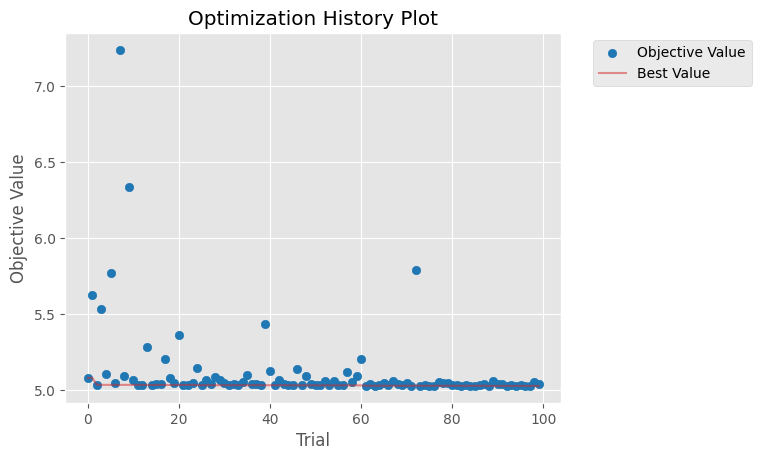

In [14]:
# Visualize optimization history
import matplotlib.pyplot as plt


# Optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)



/var/folders/dp/2nhmtbqj49v3st8xl2stwglw0000gn/T/ipykernel_57922/82623574.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
2025/10/29 20:34:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2615d3e9058c4ed7a11adb12e2169aee', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/10/29 20:34:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run enthused-bee-252 at: http://127.0.0.1:5000/#/experiments/3/runs/2615d3e9058c4ed7a11adb12e2169aee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

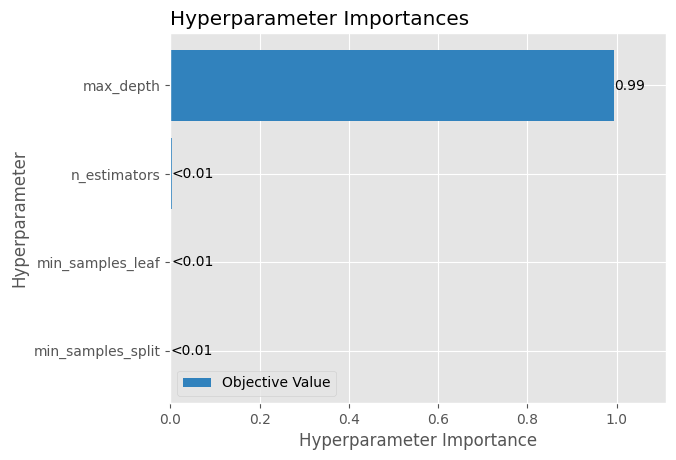

In [15]:
optuna.visualization.matplotlib.plot_param_importances(study)


# **Usando el model registry para guardar el mejor modelo y "ponerlo" en producción**

Podemos usar autlog de sklearn para captar la mayor cantidad de parametros y asi tener un modelo altamente replicable

La importancia del model registry es ya no solamente pensar en la experimentación, sino que al final, después de haber encontrado el mejor modelo pushearlo a nuestro model registry y poder usarlo en producción.

In [16]:
# Register the best model
with mlflow.start_run(run_id=study.best_trial.user_attrs.get('mlflow_run_id')):
    # Log the model
    mlflow.sklearn.log_model(
        best_model, 
        "model",
        registered_model_name="nyc-taxi-rf-optimized"
    )
    
    # Log preprocessing pipeline
    mlflow.sklearn.log_model(
        preprocessor, 
        "preprocessor",
        registered_model_name="nyc-taxi-preprocessor"
    )

2025/10/29 20:34:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/29 20:34:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/29 20:34:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'nyc-taxi-rf-optimized'.
2025/10/29 20:34:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nyc-taxi-rf-optimized, version 1
Created version '1' of model 'nyc-taxi-rf-optimized'.
2025/10/29 20:34:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/29 20:34:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/2

🏃 View run honorable-foal-30 at: http://127.0.0.1:5000/#/experiments/3/runs/f05952dcac12444dbb0a811aca987d49
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


Created version '1' of model 'nyc-taxi-preprocessor'.
